# Problem 1.1: Bank Marketing Data
Aaron Bell

# Problem Background Info:

The webpage for the dataset is located here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Simple descriptions for each column are given as follows:
Input variables:
# bank client data:
1 - age (numeric)  
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')   
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no').   
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)   
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  
  
Output variable (desired target):  
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')  

# -1) Import core packages

In [1]:
# for displaying plots in a notebook
%matplotlib inline 

import numpy as np # simply array and mathematical operations
import pandas as pd # R-like handling with dataframes, etc.
import seaborn as sb # for making your statistical plots look pretty

# 0) Data splitting

Since the dataset for problem 1.1, is already privided in a split form by the original archive. Thus we simply import the training data for the moment, and won't lay any eyes on the testing data until we have a working model.

# 1) Data loading
The pandas package allows for easy reading-in of CSV and other files. 
We'll load the data into a pandas dataframe (analagous to R dataframes), in then take a quick look at how it's stuctured.

In [2]:
from sklearn.model_selection import train_test_split


data   = pd.read_csv('data/raw/bank-additional/bank-additional-full.csv', sep = ";")
labels = data["y"].copy()
data   = data.drop("y",axis=1)

train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=1337)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27595 entries, 14401 to 3223
Data columns (total 20 columns):
age               27595 non-null int64
job               27595 non-null object
marital           27595 non-null object
education         27595 non-null object
default           27595 non-null object
housing           27595 non-null object
loan              27595 non-null object
contact           27595 non-null object
month             27595 non-null object
day_of_week       27595 non-null object
duration          27595 non-null int64
campaign          27595 non-null int64
pdays             27595 non-null int64
previous          27595 non-null int64
poutcome          27595 non-null object
emp.var.rate      27595 non-null float64
cons.price.idx    27595 non-null float64
cons.conf.idx     27595 non-null float64
euribor3m         27595 non-null float64
nr.employed       27595 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 4.4+ MB


Well, that didn't really work. While the data file was loaded, pandas interpreted it as only having one column. We'll have to specifiy other conditions when we read it. For reference: 

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

Next let's just see what the file looks like, as it's already been loaded:

In [4]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
14401,38,blue-collar,single,basic.9y,unknown,yes,no,cellular,jul,mon,72,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
35284,39,admin.,married,university.degree,no,yes,no,cellular,may,fri,364,2,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1
1225,36,blue-collar,married,basic.6y,unknown,no,no,telephone,may,thu,166,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
8289,53,self-employed,married,university.degree,no,yes,no,telephone,jun,tue,119,4,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
31412,32,technician,single,professional.course,no,yes,no,cellular,may,wed,97,2,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1


Well, as far as the columns go, pandas was probably not expecting the column names to be separated by semi-colons, as we used the read_csv function.
Let's manullay specify semi-colons as the delimiter, by sep=';'

Ok, that looks like what we want. Well, as long as columns go. Let's ask pandas to display the whole thing, to see more of the rows. Although we already know from running .info() that it found 4119 entries.

In [5]:
train.columns

Index([u'age', u'job', u'marital', u'education', u'default', u'housing',
       u'loan', u'contact', u'month', u'day_of_week', u'duration', u'campaign',
       u'pdays', u'previous', u'poutcome', u'emp.var.rate', u'cons.price.idx',
       u'cons.conf.idx', u'euribor3m', u'nr.employed'],
      dtype='object')

Ok, now that looks like a dataset! There are a few things we'll have to wrestle with. There's a lot of data attrributes (# of columns), which could be useful, but could also overcomplicate the analysis. Even if every columns helps improve our analysis, we'll still have to make sure the data take a form that our modeling efforts can use. I.e. how do you feed "basic.6y" into even a simple statistical test? With all the mixed numeric and string data, it'll be hard to even visualize. 

We can go ahead and plot up some of the numerical data first, and just see how it looks. But to really plan our next steps, we have to consider changing some of the data values from strings to binary values or integer values. Or we could take, at first, a split approach: take a look at the categorical data separately from the numerical data. Ultimately we will want all of the data we deem useful to be part of the same algorithm.



### 3) Feature Selection

We're given 21 features, which is tempting to just throw at a black-box and see what comes out.
But let's show some patience, and pre-analyze which features are the most useful, which are redundant and uninformative, and which data points have errors, etc.''

3.1) Drop columns according to the data instructions

In to the instructions, we're told that "duration" had best be omitted:  
```...the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. ``` 

In [6]:
train = train.drop("duration", axis=1)

#### 3.2) Sort quantitative from catagorical columns

Some data are given to us as numbers. Others are string labels, without an obvious way to rank them.

In [7]:
print train.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object


The quantitative data are either integer ('int64') or floats ('float64'). The qualitative, string data are given as object data type, indicatd by 'O'. We'll call the qualitative ones 'nom_cols', so we don't confuse it with 'quant_cols'.

In [8]:
train.dtypes.values

array([dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64')], dtype=object)

In [9]:
nom_cols = train.columns.values[train.dtypes == 'O']
nom_cols

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'], dtype=object)

In [10]:
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]
quant_cols

array(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], dtype=object)

Asking "How informative is this column?" is like asking "How much doest this column tell us about how data points vary from one another?". For the quantitative data, there's a straight-forward way to test this--- just take the variance. We'll first set a threshold for the variance, and then exclude columns that don't meet this threshold. A good example from scikit learn's documentations shows a variance filter of 0.8, so let's use that for the moment.

In [11]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.2)
sel.fit_transform(train[quant_cols])


print sel.variances_

print sel.get_support()

[  1.08289924e+02   7.69336085e+00   3.47097875e+04   2.41345399e-01
   2.47530405e+00   3.35146997e-01   2.15391350e+01   3.01447303e+00
   5.22720929e+03]
[ True  True  True  True  True  True  True  True  True]


In [12]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

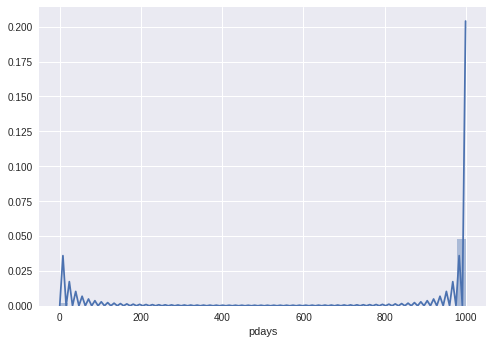

In [13]:
sb.distplot(train.pdays)

Interestingly all of our quanttative features pass the variance test. Although two of them just barely, 'pdays' and 'previous'. These two must be correlated, since you can only have a previous outcome recorded if you have a valid value for pdays. In any case, the numeric value of "999" for pdays has no meaning.

In [14]:
train = train.drop(['pdays','poutcome','previous','campaign'], axis=1)
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]
nom_cols = train.columns.values[train.dtypes == 'O']

### 4) Pre-analysis: Quantitative data cross-correlation

In [15]:
train_corrmat = train[quant_cols].corr(method="spearman")

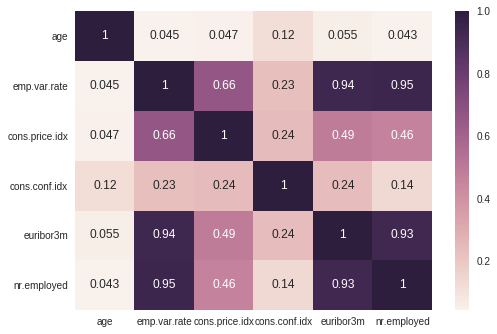

In [16]:
sb.heatmap(train_corrmat, annot=True)

Here we can see something interesting: 'euribor3m', 'nr.employed' and 'emp.var.rate' are strongly correlated.
From the data guide, we see that these are all different ways of diagnosing the socio-economic environment, at the time of the call. In other words, they don't have anything to do with the participants themselves.  

Well, it would certainly make sense that measures of the economy correlate with other measures of the economy. We want to get a simple-working model up and running as soon as possible, so let's just keep one of these metrics for the moment. It's entirely possible that we might need all 3 metrics for fine tuning, but best not to overcomplicates things from the get-go.

Which one do we drop? While they are all "quaterly" average measures, according to the instructions, only one of them gives a daily running average, and that's the 'euribor' which seems to be a measure of interest rates. Perhaps this daily variation will tell us more about the specific conditions for each caller. Admiddetly, this is a rather arbitrary choice, but we the point is to simplify the dataset while we develop a strategy.

Update: Intersting that Euribor is the one that I end up choosing here. This seems to coincide with the feature selection result in the original paper https://www.sciencedirect.com/science/article/pii/S016792361400061X

In [17]:
redundant_cols = ["nr.employed", "emp.var.rate", "cons.price.idx","cons.conf.idx"]

In [18]:
train = train.drop(redundant_cols, axis=1)
quant_cols  = train.columns.values[(train.dtypes =='int64') | (train.dtypes =='float64')]
quant_cols

array(['age', 'euribor3m'], dtype=object)

### 5) Feature-select the categorical data

A few of our data columns lend themselves to straightforward numerical relabeling. For example, January -> 1, Monday -> 2. Not to say that these have an intrinsic quantitative meaning, but it makes sense to use the conventional integer labels rather than arbitrary ones, to maximixe readability.

Some easy things we can convert are month and day of the week to 1-12 and 1-7

In [19]:
def relabelData(input_labels, input_frame, column):
    
    for i in range(0,len(input_frame[column])):
        for j in range(0,len(input_labels)):
            if input_frame[column].values[i] == input_labels[j]:
                input_frame[column].values[i] = j
                
    return input_frame[column]
                


In [20]:
#%%timeit
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']  
train.month = relabelData(months, train, "month")

# Add one so that the month numbers correspond to conventional dates - Jan = 1, etc.
train.month+=1

In [21]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,euribor3m
14401,38,blue-collar,single,basic.9y,unknown,yes,no,cellular,7,mon,4.962
35284,39,admin.,married,university.degree,no,yes,no,cellular,5,fri,1.250
1225,36,blue-collar,married,basic.6y,unknown,no,no,telephone,5,thu,4.855
8289,53,self-employed,married,university.degree,no,yes,no,telephone,6,tue,4.864
31412,32,technician,single,professional.course,no,yes,no,cellular,5,wed,1.334


Re-label days of the week

In [22]:
#%%timeit 
weekdays = ['sun','mon','tue','wed','thu','fri','sat']  
train.day_of_week = relabelData(weekdays, train,"day_of_week")

train.day_of_week+=1

train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,euribor3m
14401,38,blue-collar,single,basic.9y,unknown,yes,no,cellular,7,2,4.962
35284,39,admin.,married,university.degree,no,yes,no,cellular,5,6,1.250
1225,36,blue-collar,married,basic.6y,unknown,no,no,telephone,5,5,4.855
8289,53,self-employed,married,university.degree,no,yes,no,telephone,6,3,4.864
31412,32,technician,single,professional.course,no,yes,no,cellular,5,4,1.334


So those were fairly straightforward, since months and days of the week have an obvious order to them. Some other attributes are also fairly simple, as in marital status which has only two possible values; we can binarize it. But what do we do with things like "job" and "education"? We'll have to be a bit more arbitrary about it, if we want to do any numerical analysis or apply vectorized routines to speed things up. At least Education has a kind of chronology to it- high-school before university, and so on. If we enforce an order on something like "job" though, we're implicitly making assumptions about its correlation with other data. If we order "services" before "blue-color", then we're letting our bias about which jobs pay better, enter into the process. Conflating income level with "job".

Also, there are several columns which, despite taking numeric values, are rather opaque. It seemed safe enough to go ahead and assume "month" means month, but let's take a deeper look at the explanations given in the online archive for the other columns. The most glaring issue is that it's not apparent which column indicates the outcome of each call. The last column looks like the best bet, but let's have a quick read to be sure.

The remaining columns don't have an obvious way to integerize them. We could convert education to years of education, but then what do we do with labels like 'illiterate'? We have to be careful though, not to transform the columns that we already dealt with.

In [23]:
encode_cols = nom_cols[(nom_cols!="month") & (nom_cols!="day_of_week")].copy()
encode_cols

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact'], dtype=object)

In [24]:
from sklearn import preprocessing
nom_encoder = preprocessing.LabelEncoder()
train[encode_cols].apply(nom_encoder.fit_transform).head()

,job,marital,education,default,housing,loan,contact
14401,1,2,2,1,2,0,0
35284,0,1,6,0,2,0,0
1225,1,1,1,1,0,0,1
8289,6,1,6,0,2,0,1
31412,9,2,5,0,2,0,0


In [25]:
train[encode_cols] = train[encode_cols].apply(nom_encoder.fit_transform)
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,euribor3m
14401,38,1,2,2,1,2,0,0,7,2,4.962
35284,39,0,1,6,0,2,0,0,5,6,1.250
1225,36,1,1,1,1,0,0,1,5,5,4.855
8289,53,6,1,6,0,2,0,1,6,3,4.864
31412,32,9,2,5,0,2,0,0,5,4,1.334


In [26]:
nom_encoder.classes_

array(['cellular', 'telephone'], dtype=object)

# 7) Pre-analysis: Categorical data

Now let's take a look at some of our categorical data. For starters, just look at t he attributes that are intrinsic attribut.
es of the participant- not the phone they used, not what the economic weather was like. This leaves education, job, and age. Well, marital status, housing, financial status can arguably be "intrinsic", but let's start with the basics. 

Perhaps we can agree that age would be the most objective, quantitatve attribute of a caller, among the data we have. Let's start there:

In [27]:
# Age distributions of yesses and nos:
sb.violinplot(x="y", y="age", data=train)

ValueError: Could not interpret input 'y'

Without getting to an objective measure here, it as at least visually obvious that the yesses (1s) have a thicker tail out past the retirement ages (though we can't assume yet that all these people are "retired" per-se).

In [ ]:
# Education-age demographics
sb.violinplot(x="education", y="age",hue="y", data=train, split=True)

While this is still just a first-look at the data, it is quite interesting to see a bimodal distribution of "basic.4" folks, who said "yes". Perhaps these are the source over the over-60 tail of yessers from the previous plot.  There is a similar for the "basic.9y"s over 45 or so. Oddly, we don't see the same with "basic.6y", the intermediate education value. Let's not speculate too much yet though. 

We may want to convert these labels to "years of education", and consider applying a more quantitative analysis.

In [ ]:
# Job-age demographic
g = sb.violinplot(x="job", y="age",hue="y", data=train, split=True)
g.set_xticklabels(g.get_xticklabels(),rotation=30)

The "retired" category is interesting. Maybe we would not be wrong in assuming our retirement-aged yessers are in-fact retired. But then again, we see an extended advanced-age-tail with the "housemaid" category as well, not to mention the near-60 peak within the "unknown" category.

Now we've actually gotten a bit ahead of ourselves. Pandas may be "automatically" omitting some bad values. That's very nice of it, but we want to have our own concrete process for excluding data, rather than leaving it all up to silent built-in subroutines.

When we simplify things even further though, and just look at the distribution of ages, we see that the "violin" plots from before can be a bit misleading. While they seem to tell us that there is an overall trend with age, and retirement, and housemaids to say "yes" to the bank, the age distribution below tells us that there are very few participants over age 60. So while it may be accurate to say that, within those over 60, there is a trend to say yes- there is likely not a significant trend in this data for those who say yes to be over 60. We can't rule out a samping bias, but we do have to be careful about density plots. The reason for the confusion is that, for each side of the violin plots, the area is normalized to that category. So it falseley represents the groups is being roughly equal.

In [ ]:
sb.distplot(train.age, kde=False)

At this point it's tempting to just conclude whatever I can based on the graphs so far, but aside from "You should call elderly housemades", it is difficult to make a comprehensive recomendation. Not only that, but the simple fact that someone indicated they'd like to make a loan, does not mean that this person is a good candidate for a loan. There may be a more informative hybrid parameter in here somewhere, a combination of the given data that traces a more relevant parameter than simply job or education. I.e., probably one of the most interesting data we might want, but glaringly absent: income, or better yet, income-to-debt-ratio. Or thinking a bit further: liklihood that a given group has had, or expects, a life event that might necessitate a loan. We are not given this data directly, but the collection of our data may be tracing factors. 

Let's move towards a comprehensive method, taking all the data (or at least, all of the categorical, or all of the numeric data.) If we had all numerical data, or numerical and binary, we could perhaps apply Principal Component Analysism to pick out the most representative combinations of features in our population. However we have a well-mixed back of data types. We can try to convert data types as discussed above, or we can consider methods that are suited for categorical data, and start from there.

One option is, and I've never heard of or used it until now, Multiple Correspondance Analysis. This seems to be something of a categorical analog of Principal Component Analysis, or at least can be thought of as in the greater family of data-reprojection techniques:

https://en.wikipedia.org/wiki/Multiple_correspondence_analysis

The drive behind using the CAs, is the strategy I'd like to end up using to find structure in the data. Well, we could make a dive straight for the neural-net approach, but we have such mixed data sets and the goal itself is less well defined. Are we going to be recommending an age group? People with a certain job? Some other incredibly specific set of life circumstances? I prefer to first attempt an unsupervised approach. In this way we are forced to consider structure of the data as we go along, rather than building a black box. If this were an image recognition problem with a more restrained goal: "tell me what digit this is", I would feel better about using a neural network.

The other benefit of using a method that drags you through the data, so to speak, is that you end up learning more about datasets in general, and have more of a sense for how to approach future problems. 

Well, those are my first impressions. I may change my mind after actually trying it!

In [ ]:
# Applying an example from Stack exchange by user Napitupulu Jon, for encoding a whole pandas frame
# It got a bounty? 
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

# Experimenting with decision trees:

While I'm not an expert in decision trees-- I have only read about them -- among the methods I find for mixed-data type machine learning, I prefer it because of the relative transparency. A decision tree produces a graoh of its steps which we can easily visualize. MCA, while seemingly straightforward if we call it "PCA for categorical data", is more mathematically complex to describe. Neural nets are infamously opaque.

What follows is largely based on scikit learn examples, either from their online documentation or 
http://scikit-learn.org/stable/modules/tree.html

In [28]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,euribor3m
14401,38,1,2,2,1,2,0,0,7,2,4.962
35284,39,0,1,6,0,2,0,0,5,6,1.250
1225,36,1,1,1,1,0,0,1,5,5,4.855
8289,53,6,1,6,0,2,0,1,6,3,4.864
31412,32,9,2,5,0,2,0,0,5,4,1.334


In [31]:
from sklearn import tree

model = tree.DecisionTreeClassifier() # We are using classifier rather than regressor, because or goal is to "classify" participants into "yes" and "no" categories.

X = train.dropna()
Y = train_labels

model = model.fit(X,Y)

In [32]:
table1 = np.array([model.predict(X),Y])
pd.DataFrame(table1.T, columns=["Prediction","Reality"]).head()

,Prediction,Reality
0,no,no
1,no,no
2,no,no
3,no,no
4,no,no


Ok but of course it predicts well on the data that it is fit to.
Now we have to test!

In [33]:
model.score(X, Y)

0.98691791991302769

In [40]:
# Load testing data and apply processing steps above
print redundant_cols
print test.columns

['nr.employed', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
Index([u'age', u'job', u'marital', u'education', u'default', u'housing',
       u'loan', u'contact', u'month', u'day_of_week', u'campaign',
       u'euribor3m'],
      dtype='object')


In [47]:
#test = test.drop(redundant_cols, axis=1)
#test = test.drop("duration", axis=1)
#test = test.drop(['pdays','poutcome','previous','campaign'], axis=1)
test = test.drop('campaign',axis=1)
test.month = relabelData(months, test, "month")
test.month+=1

test.month = relabelData(weekdays, test, "day_of_week")
test.day_of_week+=1

encode_cols = nom_cols[(nom_cols!="month") & (nom_cols!="day_of_week")].copy()
encode_cols

test[encode_cols] = test[encode_cols].apply(nom_encoder.fit_transform)
test.head()



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,euribor3m
26507,37,4,1,6,0,0,0,0,7,8,4.076
40256,27,1,2,1,0,0,0,1,4,5,0.889
36042,53,9,1,5,1,2,0,0,5,6,1.266
16701,50,0,1,6,1,2,0,1,6,7,4.963
10530,50,7,2,0,0,2,0,1,5,6,4.961


In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

def reportPerformance(test_labels, predict_labels):

    print "Accuracy score: {}".format( round( 
        accuracy_score(test_labels, predict_labels)
        ,3))

    print "Precision score: {}".format(round( 
        precision_score(test_labels, predict_labels)
        ,3))

    print "Recall score: {}".format(   round( 
        recall_score(test_labels, predict_labels)
        ,3))

    print "ROC score: {}".format(   round( 
        roc_auc_score(test_labels, predict_labels)
        ,3))

It seems our model doesn't generalize very well to data it hasn't seen yet. Perhaps the tree is being over-fit to the data.
Another issue is that our number of "no"s is way higher than the number of "yesses". More than simply a classification problem, this is really a recall problem. We're hunting for needles in the haystack, rather than sorting red fish from blue fish.'

In [77]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=75,
                                      random_state=1337, 
                                      oob_score=True) # We are using classifier rather than regressor, because or goal is to "classify" participants into "yes" and "no" categories.

model_forest = model_forest.fit(train, train_labels)


predict_labels = model_forest.predict(test)

predict_labels_bin = nom_encoder.fit_transform(predict_labels)
test_labels_bin = nom_encoder.fit_transform(test_labels)

reportPerformance(test_labels_bin, predict_labels_bin)

Accuracy score: 0.883
Precision score: 0.44
Recall score: 0.233
ROC score: 0.598


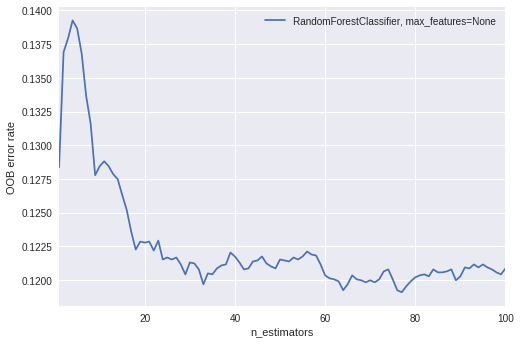

In [64]:
#Following example from stack exchange, for optimizing the number of estimators in the random forest

import matplotlib.pyplot as plt

from collections import OrderedDict


def findMinOOB(test, test_labels, min_estimators = 1, max_estimators = 100, random_state = 1337):
    
    ensemble_clfs = [ ("RandomForestClassifier, max_features=None",RandomForestClassifier(random_state=random_state,warm_start=True, max_features=None, oob_score=True,))]


    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(test, test_labels)
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))


    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
findMinOOB(test, test_labels, min_estimators = 1, max_estimators = 100, random_state = 1337)

In [ ]:
print xs[ys==np.min(ys)]

In [ ]:
# Experimenting with Neural Net

In [59]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)

clf.fit(train, train_labels)   

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [61]:
predict_labels_mlp = clf.predict(test)
predict_labels_mlp_bin = nom_encoder.fit_transform(predict_labels_mlp)

In [62]:
reportPerformance(test_labels_bin,predict_labels_mlp_bin)

Accuracy score: 0.89
Precision score: 0.5
Recall score: 0.001


# Experimenting with MCA

In [ ]:
import mca
import pandas as pd
import numpy as np

In [ ]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)

In [ ]:
ncols = len(train[nom_cols].colulmns)
mca_ben = mca.MCA(train[nom_cols], ncols=ncols)
mca_ind = mca.MCA(train[nom_cols], ncols=ncols, benzecri=False)

print mca.MCA.__doc__


In [ ]:
mca_ind.L
mca_ind.expl_var(greenacre=False, N=2)



In [ ]:
mca

In [ ]:
data = np.array([mca_ind.L[:2], 
                 mca_ind.expl_var(greenacre=False, N=2) * 100]).T
df = pd.DataFrame(data=data, columns=['cλ','%c'], index=range(1,3))
df

In [ ]:
data = np.array([mca_ind.L[:2], 
                 mca_ind.expl_var(greenacre=False, N=2) * 100]).T
df = pd.DataFrame(data=data, columns=['cλ','%c'], index=range(1,3))
df

In [ ]:
fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=train[nom_cols].index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))

table3.loc[fs,    :] = mca_ind.fs_r(N=2).T
table3.loc[cos,   :] = mca_ind.cos_r(N=2).T
table3.loc[cont,  :] = mca_ind.cont_r(N=2).T * 1000
#table3.loc[fs, 'W?'] = mca_ben.fs_r_sup(pd.DataFrame([i_sup]), N=2)[0]

np.round(table3.astype(float), 2)

In [ ]:
table4 = pd.DataFrame(columns=train[nom_cols].columns, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
table4.loc[fs,  :] = mca_ind.fs_c(N=2).T
table4.loc[cos, :] = mca_ind.cos_c(N=2).T
table4.loc[cont,:] = mca_ind.cont_c(N=2).T * 1000


np.round(table4.astype(float), 2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

points = table3.loc[fs].values
labels = table3.columns.values

plt.figure()
#plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(*points, s=120, marker='o', alpha=0.5, linewidths=0)
plt.show()


We can see that MCA pulls out a primary component of our data, explaining 73% of variance. But what we are not seeing is any kind of structure appearing in the data, such that we could easily apply a cluster-based approach like K-means.
Why? Well, maybe it's simply the case that these intrinsic properties of the participants- education job, etc., are not particularly informative when it comes to success rate for the telemarketing campaigns. 

There's one last thing we can try, which is to perform MCA with the labels as an input factor

In [ ]:
plt.hist(points[1,train.y==0])

In [ ]:
np.shape(points)
plt.scatter(points[0,:], train.y)
sb.distplot(points[0,:])

In [ ]:
sb.violinplot(np.array(points[:,:]), train.y)

In [ ]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

In [ ]:
plt.scatter(train.age, train.y)

## Feature selection:
We probably want to remove features that are not telling us anything useful about individual data points. In other words, features that have more or less the same value for all of the data. Like, the fact that all of the participants are human. This is indeed an important attribute, but tells us nothing about how one participant varies from another. Mathematically, call these low (or zero) variance features. Sklearn provides a convenient class for filtering by variance, in the Feature Selection module.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X_encoded)

In [ ]:
train.dtypes

In [ ]:
np.shape(points)